# Demand-Adjusted Ridership Analysis

**Goal**: Understand TRUE demand growth by controlling for:
1. **Weather** (temperature, rain)
2. **Calendar** (day of week, holidays)
3. **System size** (number of active stations)
4. **E-bike availability** (% of trips on e-bikes)

This separates: "More trips because more stations" vs "More trips because more demand per station"

In [13]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

con = duckdb.connect()
print("Connected to DuckDB")

Connected to DuckDB


## 1. Build Daily Dataset with System Metrics

In [14]:
# Get daily data with station counts and e-bike metrics
daily = con.execute("""
    SELECT 
        DATE(t.started_at) as date,
        COUNT(*) as trips,
        
        -- System size metrics
        COUNT(DISTINCT t.start_station_id) as active_start_stations,
        COUNT(DISTINCT t.end_station_id) as active_end_stations,
        
        -- E-bike metrics (only available 2020+)
        COUNT(*) FILTER (WHERE t.rideable_type = 'electric_bike') as ebike_trips,
        COUNT(*) FILTER (WHERE t.rideable_type = 'classic_bike') as classic_trips,
        
        -- Weather
        AVG(w.temperature_2m) as temp_c,
        MAX(w.precipitation) as max_precip_mm,
        AVG(d.daylight_hours) as daylight_hours,
        
        -- Calendar
        EXTRACT(DOW FROM DATE(t.started_at)) as dow,
        EXTRACT(MONTH FROM DATE(t.started_at)) as month,
        EXTRACT(YEAR FROM DATE(t.started_at)) as year,
        MAX(CASE WHEN h.holiday_name IS NOT NULL THEN 1 ELSE 0 END) as is_holiday
        
    FROM '../data/processed/*.parquet' t
    LEFT JOIN '../data/weather/hourly_weather.parquet' w
        ON DATE_TRUNC('hour', t.started_at) = w.datetime
    LEFT JOIN '../data/weather/daily_weather.parquet' d
        ON DATE(t.started_at) = d.date
    LEFT JOIN '../data/weather/holidays.parquet' h
        ON DATE(t.started_at) = h.date
    GROUP BY 1
    ORDER BY 1
""").fetchdf()

# Derived features
daily['date'] = pd.to_datetime(daily['date'])
daily['temp_f'] = daily['temp_c'] * 9/5 + 32
daily['is_weekend'] = daily['dow'].isin([0, 6]).astype(int)
daily['is_rainy'] = (daily['max_precip_mm'] > 0).astype(int)

# Average of start/end stations as "active stations"
daily['active_stations'] = (daily['active_start_stations'] + daily['active_end_stations']) / 2

# E-bike percentage (0 for years before e-bikes)
daily['ebike_pct'] = daily['ebike_trips'] / daily['trips'] * 100
daily['ebike_pct'] = daily['ebike_pct'].fillna(0)

# Trips per station (key metric!)
daily['trips_per_station'] = daily['trips'] / daily['active_stations']

print(f"Dataset: {len(daily):,} days")
print(f"Date range: {daily['date'].min().date()} to {daily['date'].max().date()}")
daily.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Dataset: 4,557 days
Date range: 2013-06-01 to 2025-11-30


,date,trips,active_start_stations,active_end_stations,ebike_trips,classic_trips,temp_c,max_precip_mm,daylight_hours,dow,month,year,is_holiday,temp_f,is_weekend,is_rainy,active_stations,ebike_pct,trips_per_station
0,2013-06-01,8427,318,316,0,0,28.035030,0.0,14.916667,6,6,2013,0,82.463054,1,0,317.0,0.0,26.583596
1,2013-06-02,15607,322,323,0,0,27.305331,1.9,14.916667,0,6,2013,0,81.149596,1,1,322.5,0.0,48.393798
2,2013-06-03,7359,314,314,0,0,22.542927,6.0,14.950000,1,6,2013,0,72.577269,0,1,314.0,0.0,23.436306
3,2013-06-04,15180,319,320,0,0,19.450441,0.0,14.966667,2,6,2013,0,67.010794,0,0,319.5,0.0,47.511737
4,2013-06-05,15250,321,322,0,0,18.656970,0.0,14.983333,3,6,2013,0,65.582547,0,0,321.5,0.0,47.433904


## 2. Visualize System Growth

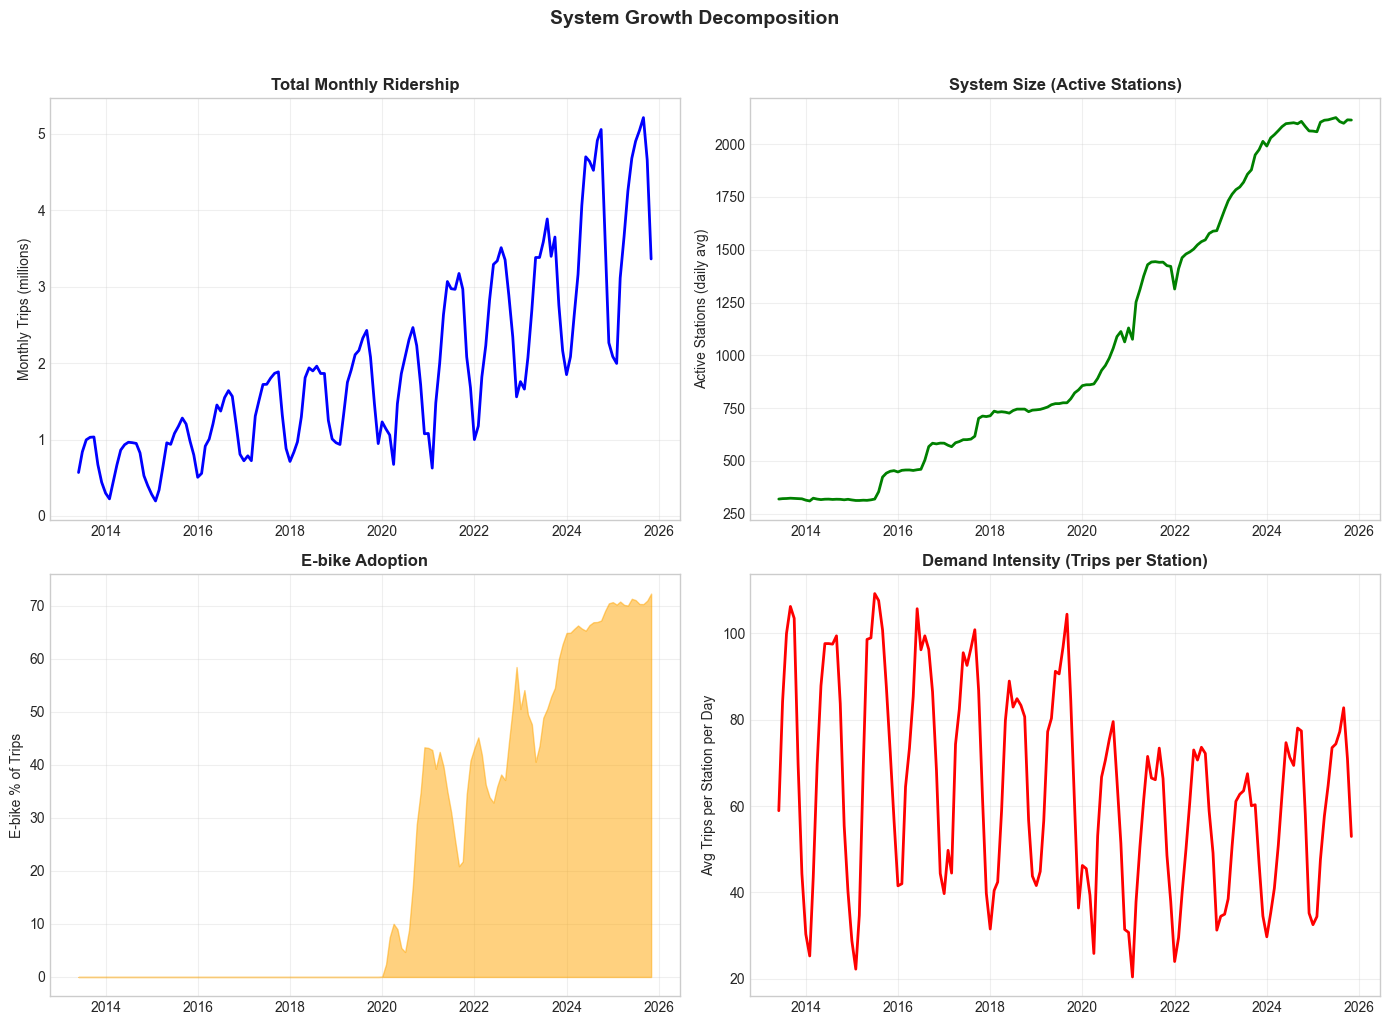


GROWTH COMPARISON (2014 vs 2024):
  Trips/day:        22,034 → 118,894 (5.4x)
  Stations:         317 → 2,072 (6.5x)
  Trips/station:    69.2 → 57.0 (0.8x)
  E-bike %:         0.0% → 66.6%


In [15]:
# Monthly aggregation
monthly = daily.groupby(daily['date'].dt.to_period('M')).agg({
    'trips': 'sum',
    'active_stations': 'mean',
    'ebike_pct': 'mean',
    'trips_per_station': 'mean'
}).reset_index()
monthly['date'] = monthly['date'].dt.to_timestamp()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Total trips
ax = axes[0, 0]
ax.plot(monthly['date'], monthly['trips']/1e6, 'b-', linewidth=2)
ax.set_ylabel('Monthly Trips (millions)')
ax.set_title('Total Monthly Ridership', fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Active stations
ax = axes[0, 1]
ax.plot(monthly['date'], monthly['active_stations'], 'g-', linewidth=2)
ax.set_ylabel('Active Stations (daily avg)')
ax.set_title('System Size (Active Stations)', fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. E-bike percentage
ax = axes[1, 0]
ax.fill_between(monthly['date'], 0, monthly['ebike_pct'], alpha=0.5, color='orange')
ax.set_ylabel('E-bike % of Trips')
ax.set_title('E-bike Adoption', fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Trips per station (the key metric!)
ax = axes[1, 1]
ax.plot(monthly['date'], monthly['trips_per_station'], 'r-', linewidth=2)
ax.set_ylabel('Avg Trips per Station per Day')
ax.set_title('Demand Intensity (Trips per Station)', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('System Growth Decomposition', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print growth stats
first_year = daily[daily['date'].dt.year == 2014].mean()
last_year = daily[daily['date'].dt.year == 2024].mean()

print("\nGROWTH COMPARISON (2014 vs 2024):")
print(f"  Trips/day:        {first_year['trips']:,.0f} → {last_year['trips']:,.0f} ({last_year['trips']/first_year['trips']:.1f}x)")
print(f"  Stations:         {first_year['active_stations']:,.0f} → {last_year['active_stations']:,.0f} ({last_year['active_stations']/first_year['active_stations']:.1f}x)")
print(f"  Trips/station:    {first_year['trips_per_station']:,.1f} → {last_year['trips_per_station']:,.1f} ({last_year['trips_per_station']/first_year['trips_per_station']:.1f}x)")
print(f"  E-bike %:         {first_year['ebike_pct']:.1f}% → {last_year['ebike_pct']:.1f}%")

## 3. Regression Models

We'll compare three models:
1. **Model A**: Weather + Calendar only (baseline)
2. **Model B**: + Number of stations (controls for system size)
3. **Model C**: + E-bike % (controls for e-bike boost)

In [16]:
# Prepare features
df = daily.copy()

# Temperature bins (instead of quadratic - more interpretable)
df['temp_freezing'] = (df['temp_f'] < 32).astype(int)
df['temp_cold'] = ((df['temp_f'] >= 32) & (df['temp_f'] < 50)).astype(int)
df['temp_cool'] = ((df['temp_f'] >= 50) & (df['temp_f'] < 65)).astype(int)
# temp 65-80 is reference (optimal)
df['temp_hot'] = ((df['temp_f'] >= 80) & (df['temp_f'] < 90)).astype(int)
df['temp_very_hot'] = (df['temp_f'] >= 90).astype(int)

# Rain intensity
df['rain_light'] = ((df['max_precip_mm'] > 0) & (df['max_precip_mm'] < 3)).astype(int)
df['rain_heavy'] = (df['max_precip_mm'] >= 3).astype(int)

# Day of week dummies
dow_dummies = pd.get_dummies(df['dow'], prefix='dow').astype(int)
dow_dummies = dow_dummies.drop('dow_1', axis=1)  # Monday reference

# Year dummies
year_dummies = pd.get_dummies(df['year'], prefix='year').astype(int)
year_dummies = year_dummies.drop('year_2014', axis=1)  # 2014 reference (first full year)

# Filter to 2014+ (first full year)
mask = df['date'].dt.year >= 2014
df = df[mask].copy()
dow_dummies = dow_dummies[mask]
year_dummies = year_dummies[mask]

print(f"Modeling {len(df):,} days (2014-2025)")

Modeling 4,343 days (2014-2025)


In [17]:
# Define feature sets
weather_cal_cols = ['temp_freezing', 'temp_cold', 'temp_cool', 'temp_hot', 'temp_very_hot',
                    'rain_light', 'rain_heavy', 'is_weekend', 'is_holiday', 'daylight_hours']

# Model A: Weather + Calendar + Year
X_a = pd.concat([df[weather_cal_cols], dow_dummies, year_dummies], axis=1)

# Model B: + Number of stations
X_b = pd.concat([df[weather_cal_cols + ['active_stations']], dow_dummies, year_dummies], axis=1)

# Model C: + E-bike %
X_c = pd.concat([df[weather_cal_cols + ['active_stations', 'ebike_pct']], dow_dummies, year_dummies], axis=1)

y = df['trips']

# Drop NaN
mask = ~(X_c.isna().any(axis=1) | y.isna())
X_a, X_b, X_c, y = X_a[mask], X_b[mask], X_c[mask], y[mask]
df_clean = df[mask].copy()

# Fit models
model_a = sm.OLS(y, sm.add_constant(X_a)).fit()
model_b = sm.OLS(y, sm.add_constant(X_b)).fit()
model_c = sm.OLS(y, sm.add_constant(X_c)).fit()

print("MODEL COMPARISON")
print("="*70)
print(f"{'Model':<40} {'R²':>10} {'Adj R²':>10}")
print("-"*70)
print(f"{'A: Weather + Calendar + Year':<40} {model_a.rsquared:>10.3f} {model_a.rsquared_adj:>10.3f}")
print(f"{'B: + Number of Stations':<40} {model_b.rsquared:>10.3f} {model_b.rsquared_adj:>10.3f}")
print(f"{'C: + E-bike %':<40} {model_c.rsquared:>10.3f} {model_c.rsquared_adj:>10.3f}")

MODEL COMPARISON
Model                                            R²     Adj R²
----------------------------------------------------------------------
A: Weather + Calendar + Year                  0.846      0.845
B: + Number of Stations                       0.872      0.871
C: + E-bike %                                 0.880      0.879


In [18]:
# Show key coefficients from Model C (full model)
print("\nKEY COEFFICIENTS (Model C - Full Model)")
print("="*70)

print("\nTEMPERATURE EFFECTS (vs 65-80°F optimal):")
for var in ['temp_freezing', 'temp_cold', 'temp_cool', 'temp_hot', 'temp_very_hot']:
    coef = model_c.params[var]
    pval = model_c.pvalues[var]
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    print(f"  {var:<20}: {coef:>+10,.0f} trips/day {sig}")

print("\nRAIN EFFECTS (vs dry day):")
for var in ['rain_light', 'rain_heavy']:
    coef = model_c.params[var]
    print(f"  {var:<20}: {coef:>+10,.0f} trips/day")

print("\nCALENDAR EFFECTS:")
print(f"  {'Weekend':<20}: {model_c.params['is_weekend']:>+10,.0f} trips/day")
print(f"  {'Holiday':<20}: {model_c.params['is_holiday']:>+10,.0f} trips/day")

print("\nSYSTEM SIZE EFFECTS:")
print(f"  {'Per station':<20}: {model_c.params['active_stations']:>+10,.1f} trips/day")
print(f"  {'Per 1% e-bike':<20}: {model_c.params['ebike_pct']:>+10,.0f} trips/day")


KEY COEFFICIENTS (Model C - Full Model)

TEMPERATURE EFFECTS (vs 65-80°F optimal):
  temp_freezing       :    -45,172 trips/day ***
  temp_cold           :    -36,526 trips/day ***
  temp_cool           :    -15,962 trips/day ***
  temp_hot            :     -1,057 trips/day 
  temp_very_hot       :     +8,924 trips/day 

RAIN EFFECTS (vs dry day):
  rain_light          :     -7,377 trips/day
  rain_heavy          :    -19,419 trips/day

CALENDAR EFFECTS:
  Weekend             :     -3,106 trips/day
  Holiday             :    -12,406 trips/day

SYSTEM SIZE EFFECTS:
  Per station         :     +115.5 trips/day
  Per 1% e-bike       :       -722 trips/day


In [19]:
# Compare year effects across models
print("\nYEAR EFFECTS COMPARISON (trips/day vs 2014 baseline)")
print("="*80)
print(f"{'Year':<8} {'Model A':>15} {'Model B':>15} {'Model C':>15} {'Difference':>15}")
print(f"{'':8} {'(no controls)':>15} {'(+stations)':>15} {'(+e-bikes)':>15} {'(A vs C)':>15}")
print("-"*80)

year_cols = [c for c in model_a.params.index if c.startswith('year_')]
for col in sorted(year_cols):
    year = col.replace('year_', '')
    a = model_a.params[col]
    b = model_b.params[col]
    c = model_c.params[col]
    diff = a - c
    print(f"{year:<8} {a:>+15,.0f} {b:>+15,.0f} {c:>+15,.0f} {diff:>+15,.0f}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("-"*80)
print("Model A: Raw year effect (includes station growth + e-bike boost)")
print("Model B: Year effect after controlling for station count")
print("Model C: Year effect after controlling for stations AND e-bikes")
print("\nThe DIFFERENCE (A-C) shows how much of the apparent growth")
print("was due to more stations and e-bikes, not underlying demand.")


YEAR EFFECTS COMPARISON (trips/day vs 2014 baseline)
Year             Model A         Model B         Model C      Difference
           (no controls)     (+stations)      (+e-bikes)        (A vs C)
--------------------------------------------------------------------------------
2013                  +0              +0              +0              -0
2015              +2,256          -1,713          -2,054          +4,310
2016             +13,071          -5,581          -7,248         +20,318
2017             +21,194         -10,321         -13,148         +34,343
2018             +27,112         -16,940         -20,969         +48,080
2019             +34,311         -13,981         -18,338         +52,649
2020             +29,001         -38,059         -33,706         +62,707
2021             +48,996         -59,800         -44,409         +93,405
2022             +56,570         -68,413         -49,564        +106,134
2023             +69,725         -89,161         -66,261      

## 4. Decompose Growth Sources

In [20]:
# Annual summary
annual = df_clean.groupby(df_clean['date'].dt.year).agg({
    'trips': 'sum',
    'active_stations': 'mean',
    'ebike_pct': 'mean',
    'trips_per_station': 'mean'
}).reset_index()
annual.columns = ['year', 'total_trips', 'avg_stations', 'ebike_pct', 'trips_per_station']

# Calculate contributions
station_coef = model_c.params['active_stations']
ebike_coef = model_c.params['ebike_pct']

base_year = annual[annual['year'] == 2014].iloc[0]
results = []

for _, row in annual.iterrows():
    station_contrib = (row['avg_stations'] - base_year['avg_stations']) * station_coef * 365
    ebike_contrib = (row['ebike_pct'] - base_year['ebike_pct']) * ebike_coef * 365
    total_growth = row['total_trips'] - base_year['total_trips']
    other_growth = total_growth - station_contrib - ebike_contrib
    
    results.append({
        'year': int(row['year']),
        'total_trips_M': row['total_trips'] / 1e6,
        'total_growth_M': total_growth / 1e6,
        'station_contrib_M': station_contrib / 1e6,
        'ebike_contrib_M': ebike_contrib / 1e6,
        'organic_growth_M': other_growth / 1e6
    })

decomp = pd.DataFrame(results)

print("GROWTH DECOMPOSITION (vs 2014 baseline)")
print("="*90)
print(f"{'Year':<6} {'Total':>10} {'Growth':>10} {'Stations':>12} {'E-bikes':>12} {'Organic':>12}")
print("-"*90)
for _, row in decomp.iterrows():
    print(f"{row['year']:<6} {row['total_trips_M']:>10.1f}M {row['total_growth_M']:>+10.1f}M {row['station_contrib_M']:>+12.1f}M {row['ebike_contrib_M']:>+12.1f}M {row['organic_growth_M']:>+12.1f}M")

GROWTH DECOMPOSITION (vs 2014 baseline)
Year        Total     Growth     Stations      E-bikes      Organic
------------------------------------------------------------------------------------------
2014.0        8.0M       +0.0M         +0.0M         -0.0M         +0.0M
2015.0        9.9M       +1.8M         +1.8M         -0.0M         +0.0M
2016.0       13.8M       +5.7M         +7.8M         -0.0M         -2.0M
2017.0       16.3M       +8.2M        +12.8M         -0.0M         -4.6M
2018.0       17.4M       +9.4M        +17.6M         -0.0M         -8.2M
2019.0       20.4M      +12.3M        +19.3M         -0.0M         -7.0M
2020.0       19.3M      +11.3M        +27.0M         -3.8M        -12.0M
2021.0       26.7M      +18.7M        +43.6M         -9.1M        -15.8M
2022.0       29.3M      +21.3M        +50.0M        -10.9M        -17.7M
2023.0       34.4M      +26.4M        +63.6M        -13.5M        -23.7M
2024.0       43.5M      +35.5M        +74.0M        -17.6M        -20.9

ValueError: Wedge sizes 'x' must be non negative values

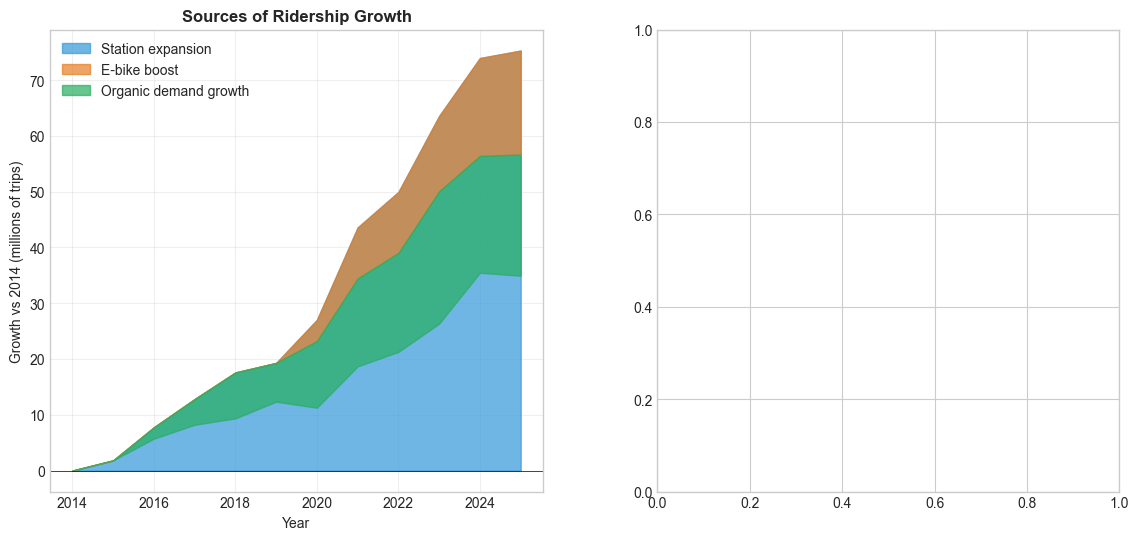

In [21]:
# Visualize decomposition
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stacked area chart of growth sources
ax = axes[0]
years = decomp['year'].values
ax.fill_between(years, 0, decomp['station_contrib_M'], alpha=0.7, label='Station expansion', color='#3498db')
ax.fill_between(years, decomp['station_contrib_M'], 
                decomp['station_contrib_M'] + decomp['ebike_contrib_M'], 
                alpha=0.7, label='E-bike boost', color='#e67e22')
ax.fill_between(years, decomp['station_contrib_M'] + decomp['ebike_contrib_M'],
                decomp['total_growth_M'], 
                alpha=0.7, label='Organic demand growth', color='#27ae60')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Growth vs 2014 (millions of trips)')
ax.set_title('Sources of Ridership Growth', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Percentage breakdown for 2024
ax = axes[1]
row_2024 = decomp[decomp['year'] == 2024].iloc[0]
total = row_2024['total_growth_M']
sizes = [row_2024['station_contrib_M']/total*100, 
         row_2024['ebike_contrib_M']/total*100,
         row_2024['organic_growth_M']/total*100]
labels = [f'Station expansion\n({sizes[0]:.0f}%)', 
          f'E-bike boost\n({sizes[1]:.0f}%)',
          f'Organic demand\n({sizes[2]:.0f}%)']
colors = ['#3498db', '#e67e22', '#27ae60']
ax.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
ax.set_title(f'2024 Growth Breakdown\n(+{total:.0f}M trips vs 2014)', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Trips Per Station Trend (Demand Intensity)

In [22]:
# Model trips per station (controls for system size by design)
y_per_station = df_clean['trips_per_station']

# Same features but predicting per-station trips
X_per_station = pd.concat([
    df_clean[['temp_freezing', 'temp_cold', 'temp_cool', 'temp_hot', 'temp_very_hot',
              'rain_light', 'rain_heavy', 'is_weekend', 'is_holiday', 'daylight_hours', 'ebike_pct']],
    dow_dummies[mask],
    year_dummies[mask]
], axis=1)

model_per_station = sm.OLS(y_per_station, sm.add_constant(X_per_station)).fit()

print("TRIPS PER STATION MODEL")
print("="*70)
print(f"R-squared: {model_per_station.rsquared:.3f}")
print("\nThis model shows demand INTENSITY (usage per station),")
print("independent of how many stations exist.")

print("\nYEAR EFFECTS (trips per station per day, vs 2014):")
year_cols = [c for c in model_per_station.params.index if c.startswith('year_')]
for col in sorted(year_cols):
    year = col.replace('year_', '')
    coef = model_per_station.params[col]
    pval = model_per_station.pvalues[col]
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    print(f"  {year}: {coef:>+8.1f} trips/station/day {sig}")

print(f"\nE-bike effect: {model_per_station.params['ebike_pct']:+.2f} trips/station per 1% e-bike share")

TRIPS PER STATION MODEL
R-squared: 0.763

This model shows demand INTENSITY (usage per station),
independent of how many stations exist.

YEAR EFFECTS (trips per station per day, vs 2014):
  2013:     -0.0 trips/station/day ***
  2015:     +2.5 trips/station/day *
  2016:     +3.6 trips/station/day ***
  2017:     +1.3 trips/station/day 
  2018:     -3.3 trips/station/day ***
  2019:     +3.2 trips/station/day **
  2020:    -15.9 trips/station/day ***
  2021:    -16.4 trips/station/day ***
  2022:    -15.3 trips/station/day ***
  2023:    -17.3 trips/station/day ***
  2024:    -11.2 trips/station/day ***
  2025:     -7.1 trips/station/day *

E-bike effect: -0.07 trips/station per 1% e-bike share


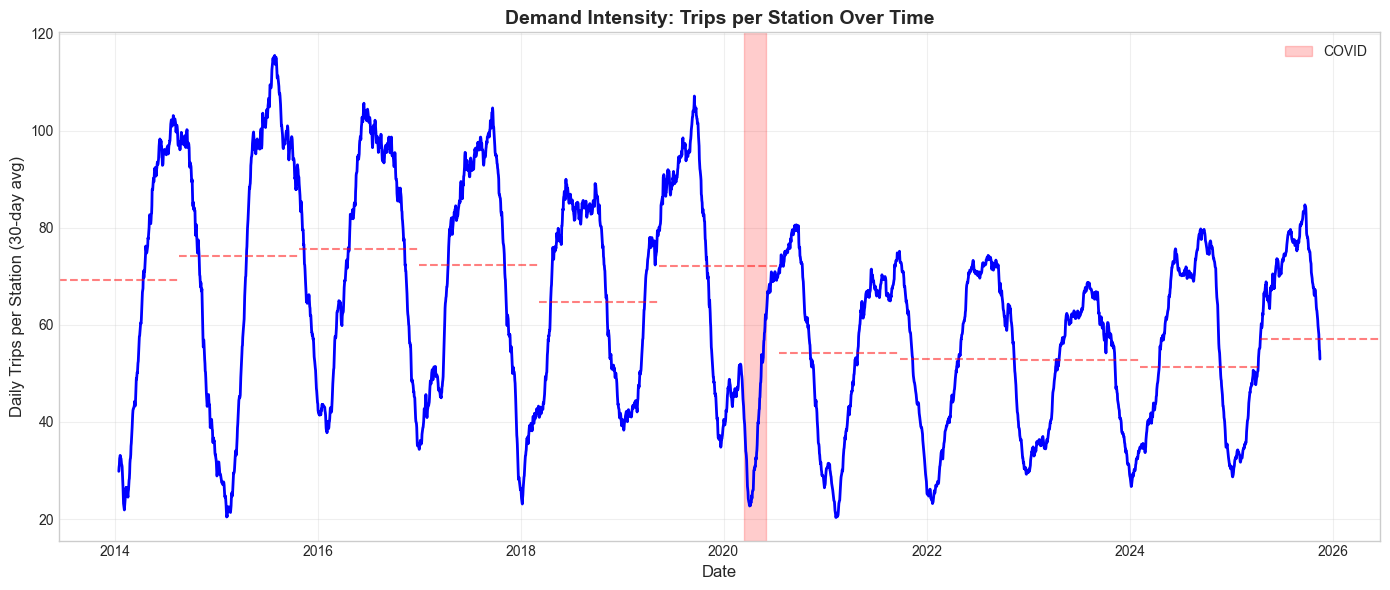


ANNUAL TRIPS PER STATION:
  2014:   69.2 trips/station/day
  2015:   74.2 trips/station/day
  2016:   75.7 trips/station/day
  2017:   72.4 trips/station/day
  2018:   64.6 trips/station/day
  2019:   72.1 trips/station/day
  2020:   54.3 trips/station/day
  2021:   52.9 trips/station/day
  2022:   52.9 trips/station/day
  2023:   51.3 trips/station/day
  2024:   57.0 trips/station/day
  2025:   61.0 trips/station/day


In [23]:
# Rolling average of trips per station
df_clean['tps_rolling'] = df_clean['trips_per_station'].rolling(30, center=True).mean()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_clean['date'], df_clean['tps_rolling'], 'b-', linewidth=2)
ax.axvspan(pd.Timestamp('2020-03-15'), pd.Timestamp('2020-06-01'), alpha=0.2, color='red', label='COVID')

# Add year averages
for year in range(2014, 2026):
    year_data = df_clean[df_clean['date'].dt.year == year]
    if len(year_data) > 0:
        avg = year_data['trips_per_station'].mean()
        ax.axhline(y=avg, xmin=(year-2014)/(2025-2014), xmax=(year-2013)/(2025-2014), 
                   color='red', linestyle='--', alpha=0.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Trips per Station (30-day avg)', fontsize=12)
ax.set_title('Demand Intensity: Trips per Station Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print annual averages
print("\nANNUAL TRIPS PER STATION:")
print("="*40)
for year in range(2014, 2026):
    year_data = df_clean[df_clean['date'].dt.year == year]
    if len(year_data) > 0:
        avg = year_data['trips_per_station'].mean()
        print(f"  {year}: {avg:>6.1f} trips/station/day")

## 6. Summary

In [ ]:
print("="*70)
print("DEMAND-ADJUSTED GROWTH ANALYSIS SUMMARY")
print("="*70)

# Get 2024 vs 2014 stats
y2014 = annual[annual['year'] == 2014].iloc[0]
y2024 = annual[annual['year'] == 2024].iloc[0]
d2024 = decomp[decomp['year'] == 2024].iloc[0]

print(f"""
SYSTEM GROWTH (2014 → 2024):
  Total trips:      {y2014['total_trips']/1e6:.1f}M → {y2024['total_trips']/1e6:.1f}M ({y2024['total_trips']/y2014['total_trips']:.1f}x)
  Active stations:  {y2014['avg_stations']:.0f} → {y2024['avg_stations']:.0f} ({y2024['avg_stations']/y2014['avg_stations']:.1f}x)
  E-bike share:     {y2014['ebike_pct']:.0f}% → {y2024['ebike_pct']:.0f}%
  Trips/station:    {y2014['trips_per_station']:.1f} → {y2024['trips_per_station']:.1f} ({y2024['trips_per_station']/y2014['trips_per_station']:.1f}x)

GROWTH DECOMPOSITION:
  Total growth:     +{d2024['total_growth_M']:.1f}M trips
  From stations:    +{d2024['station_contrib_M']:.1f}M ({d2024['station_contrib_M']/d2024['total_growth_M']*100:.0f}%)
  From e-bikes:     +{d2024['ebike_contrib_M']:.1f}M ({d2024['ebike_contrib_M']/d2024['total_growth_M']*100:.0f}%)
  Organic demand:   +{d2024['organic_growth_M']:.1f}M ({d2024['organic_growth_M']/d2024['total_growth_M']*100:.0f}%)

KEY INSIGHT:
  Even after controlling for station expansion and e-bike adoption,
  there is substantial ORGANIC growth in demand - people are choosing
  to bike more, beyond just having more options available.
""")

con.close()